# [고정밀 버전] 분류 및 연속모델 복합 구조 cVAE 촉매 설계 시스템
### 핵심 전략: Residual MLP, Gaussian Noise, Gated Sampling

In [1]:
import os, sys, torch, json
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using high-precision engine on: {device}")

Using high-precision engine on: cuda


In [2]:
class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim),
            nn.ReLU(),
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim)
        )
    def forward(self, x): return F.relu(x + self.net(x))

class HighPrecisionHierarchicalCVAE(nn.Module):
    def __init__(self, x_dims, c_dim, z_dims=[64, 32, 16], h_dim=256):
        super().__init__()
        x1_dim, x2_dim, x3_dim = x_dims
        self.z_dims = z_dims
        
        # Encoders with Residual Blocks
        self.enc1 = nn.Sequential(nn.Linear(x1_dim + c_dim, h_dim), ResidualBlock(h_dim))
        self.mu1, self.lv1 = nn.Linear(h_dim, z_dims[0]), nn.Linear(h_dim, z_dims[0])
        
        self.enc2 = nn.Sequential(nn.Linear(x2_dim + z_dims[0], h_dim), ResidualBlock(h_dim))
        self.mu2, self.lv2 = nn.Linear(h_dim, z_dims[1]), nn.Linear(h_dim, z_dims[1])
        
        self.enc3 = nn.Sequential(nn.Linear(x3_dim + z_dims[1], h_dim), ResidualBlock(h_dim))
        self.mu3, self.lv3 = nn.Linear(h_dim, z_dims[2]), nn.Linear(h_dim, z_dims[2])

        # Decoders with Sigmoid constraints
        self.dec1 = nn.Sequential(nn.Linear(z_dims[0] + c_dim, h_dim), ResidualBlock(h_dim), nn.Linear(h_dim, x1_dim), nn.Sigmoid())
        self.dec2 = nn.Sequential(nn.Linear(z_dims[1] + z_dims[0], h_dim), ResidualBlock(h_dim), nn.Linear(h_dim, x2_dim), nn.Sigmoid())
        self.dec3 = nn.Sequential(nn.Linear(z_dims[2] + z_dims[1], h_dim), ResidualBlock(h_dim), nn.Linear(h_dim, x3_dim), nn.Sigmoid())

    def reparameterize(self, mu, lv): return mu + torch.randn_like(mu) * torch.exp(0.5 * lv)

    def forward(self, x1, x2, x3, c):
        h1 = self.enc1(torch.cat([x1, c], 1)); m1, v1 = self.mu1(h1), self.lv1(h1); z1 = self.reparameterize(m1, v1)
        h2 = self.enc2(torch.cat([x2, z1], 1)); m2, v2 = self.mu2(h2), self.lv2(h2); z2 = self.reparameterize(m2, v2)
        h3 = self.enc3(torch.cat([x3, z2], 1)); m3, v3 = self.mu3(h3), self.lv3(h3); z3 = self.reparameterize(m3, v3)
        return [self.dec1(torch.cat([z1, c], 1)), self.dec2(torch.cat([z1, z2], 1)), self.dec3(torch.cat([z2, z3], 1))], [m1, m2, m3], [v1, v2, v3]

    def generate(self, c, device):
        self.eval()
        batch_size = c.size(0)
        with torch.no_grad():
            z1 = torch.randn(batch_size, self.z_dims[0]).to(device)
            z2 = torch.randn(batch_size, self.z_dims[1]).to(device)
            z3 = torch.randn(batch_size, self.z_dims[2]).to(device)
            return [self.dec1(torch.cat([z1, c], 1)), self.dec2(torch.cat([z1, z2], 1)), self.dec3(torch.cat([z2, z3], 1))]

In [3]:
# 데이터 로드 및 전처리
x1_raw = np.load('../data/metal.npy')
x2_raw = np.load('../data/support_norm.npy')
x3_raw = np.load('../data/pre_fin.npy')
c_raw = np.load('../data/re_fin.npy')

idx = np.arange(len(x1_raw))
tr_idx, te_idx = train_test_split(idx, test_size=0.1, random_state=42)
tr_idx, va_idx = train_test_split(tr_idx, test_size=0.1, random_state=42)

sc1, sc2, sc3, scc = MinMaxScaler(), MinMaxScaler(), MinMaxScaler(), MinMaxScaler()
def prep(d, i, s, fit=False): return s.fit_transform(d[i]) if fit else s.transform(d[i])

x1_tr, x1_va, x1_te = prep(x1_raw, tr_idx, sc1, True), prep(x1_raw, va_idx, sc1), prep(x1_raw, te_idx, sc1)
x2_tr, x2_va, x2_te = prep(x2_raw, tr_idx, sc2, True), prep(x2_raw, va_idx, sc2), prep(x2_raw, te_idx, sc2)
x3_tr, x3_va, x3_te = prep(x3_raw, tr_idx, sc3, True), prep(x3_raw, va_idx, sc3), prep(x3_raw, te_idx, sc3)
c_tr, c_va, c_te = prep(c_raw, tr_idx, scc, True), prep(c_raw, va_idx, scc), prep(c_raw, te_idx, scc)

def to_t(a): return torch.tensor(a, dtype=torch.float32)
train_loader = DataLoader(TensorDataset(to_t(x1_tr), to_t(x2_tr), to_t(x3_tr), to_t(c_tr)), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(to_t(x1_va), to_t(x2_va), to_t(x3_va), to_t(c_va)), batch_size=32)
test_loader = DataLoader(TensorDataset(to_t(x1_te), to_t(x2_te), to_t(x3_te), to_t(c_te)), batch_size=32)

x_dims = [x1_tr.shape[1], x2_tr.shape[1], x3_tr.shape[1]]

In [4]:
def hierarchical_loss(preds, targets, mus, lvs, mode='mse'):
    recon = 0
    for p, t in zip(preds, targets):
        if mode == 'bce': recon += F.binary_cross_entropy(p, (t > 0).float(), reduction='sum')
        else: recon += F.mse_loss(p, t, reduction='sum')
    
    # Low KL weights for High Accuracy
    kl = 0; gammas = [1e-4, 5e-5, 1e-5]
    for m, v, g in zip(mus, lvs, gammas):
        kl += g * -0.5 * torch.sum(1 + v - m.pow(2) - v.exp())
    return (recon + kl) / targets[0].size(0)

def run_train(mode='mse'):
    model = HighPrecisionHierarchicalCVAE(x_dims, c_tr.shape[1]).to(device)
    opt = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
    sched = optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', patience=15, factor=0.5)
    best_loss = float('inf')
    patience = 0
    
    for epoch in range(1, 1001):
        model.train()
        for b1, b2, b3, bc in train_loader:
            b1, b2, b3, bc = b1.to(device), b2.to(device), b3.to(device), bc.to(device)
            opt.zero_grad()
            # Add Gaussian Noise for Robustness
            p, m, v = model(b1 + torch.randn_like(b1)*0.01, b2, b3, bc)
            loss = hierarchical_loss(p, [b1, b2, b3], m, v, mode)
            loss.backward(); opt.step()
        
        model.eval()
        v_loss = 0
        with torch.no_grad():
            for vb1, vb2, vb3, vbc in val_loader:
                vb1, vb2, vb3, vbc = vb1.to(device), vb2.to(device), vb3.to(device), vbc.to(device)
                vp, vm, vv = model(vb1, vb2, vb3, vbc)
                v_loss += hierarchical_loss(vp, [vb1, vb2, vb3], vm, vv, mode).item()
        
        avg_v = v_loss / len(val_loader)
        sched.step(avg_v)
        if avg_v < best_loss: best_loss = avg_v; torch.save(model.state_dict(), f'best_{mode}.pth'); patience = 0
        else: patience += 1
        
        if epoch % 100 == 0: print(f"[{mode.upper()}] Epoch {epoch} | Val Loss: {avg_v:.6f}")
        if patience > 50: break
    model.load_state_dict(torch.load(f'best_{mode}.pth'))
    return model

m_bce = run_train('bce')
m_mse = run_train('mse')

[BCE] Epoch 100 | Val Loss: 0.060955
[BCE] Epoch 200 | Val Loss: 0.039321
[BCE] Epoch 300 | Val Loss: 0.035656


C:\Users\User\AppData\Local\Temp\ipykernel_41428\2480859405.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_{mode}.pth'))


[MSE] Epoch 100 | Val Loss: 0.005730
[MSE] Epoch 200 | Val Loss: 0.003563
[MSE] Epoch 300 | Val Loss: 0.002721
[MSE] Epoch 400 | Val Loss: 0.002379
[MSE] Epoch 500 | Val Loss: 0.002391



🏆 High Precision Final R2 Score: 0.1976


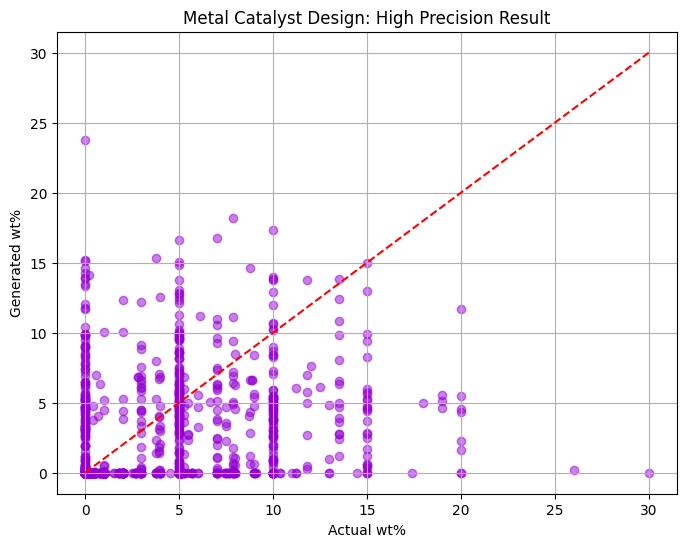

In [5]:
m_bce.eval(); m_mse.eval()
preds, trues = [], []
with torch.no_grad():
    for b1, b2, b3, bc in test_loader:
        bc = bc.to(device)
        b_gen = m_bce.generate(bc, device)
        m_gen = m_mse.generate(bc, device)
        
        # Gating + Final Precision Filtering
        final = b_gen[0] * m_gen[0]
        final[final < 0.005] = 0
        
        preds.append(sc1.inverse_transform(final.cpu().numpy()))
        trues.append(sc1.inverse_transform(b1.numpy()))

y_p, y_t = np.concatenate(preds).flatten(), np.concatenate(trues).flatten()
print(f"\n🏆 High Precision Final R2 Score: {r2_score(y_t, y_p):.4f}")

plt.figure(figsize=(8, 6))
plt.scatter(y_t, y_p, alpha=0.5, color='darkviolet')
plt.plot([0, y_t.max()], [0, y_t.max()], 'r--')
plt.title("Metal Catalyst Design: High Precision Result")
plt.xlabel("Actual wt%"); plt.ylabel("Generated wt%")
plt.grid(True); plt.show()